<a href="https://colab.research.google.com/github/JGRimst/ML/blob/Assignment_2/Copy_of_ass_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler, StandardScalar

from tensorflow.keras import Sequential

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.deterministic import Seasonality, DeterministicProcess, TimeTrend
from statsmodels.tsa.vector_ar import var_model
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'StandardScalar' from 'sklearn.preprocessing' (/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/__init__.py)

In [ ]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_test_tensors(X, y, sequence_length, batch_size):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  scaler = StandardScalar(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  # val_dataset = scaler.transform(X_val)
  X_test = scaler.transform(X_test)

  y_train = scaler.fit_transform(y_train.reshape(-1, 1))
  # val_dataset = scaler.transform(y_val
  y_test = scaler.transform(y_test.reshape(-1,1))

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  # val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


  # Assuming your dataset is a pandas DataFrame or a NumPy array

  # Batch and shuffle
  batch_size = batch_size
  train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  # val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return train_dataset, test_dataset


# Define a custom RNN cell (e.g., Jordan RNN)
class JordanRNNCell(layers.Layer):
    def __init__(self, units, output_size, activation, **kwargs):
        super(JordanRNNCell, self).__init__(**kwargs)
        self.units = units
        self.output_size = output_size
        self.activation = activation

    @property
    def state_size(self):
        return self.output_size

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
        self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')
        self.b_h = self.add_weight(shape=(self.units,), name='b_h')
        self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')
        self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

    def call(self, inputs, states):
        prev_output = states[0]

        h = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_output, self.W_oh) + self.b_h
        h = self.activation(h)
        y = tf.matmul(h, self.W_hy) + self.b_y
        return y, [y]

class MRNNcell(layers.Layer):
  def __init__(self, units, output_size, activation, **kwargs):
      super(MRNNcell, self).__init__(**kwargs)
      self.units = units
      self.output_size = output_size
      self.activation = activation

  @property
  def state_size(self):
      return [self.units, self.output_size]

  def build(self, input_shape):
      input_dim = input_shape[-1]
      ##Jordan ## outputs of previous time step
      self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')

      ## Elman ## feedback from hidden units after activation
      self.W_feedback = self.add_weight(shape=(self.units, self.units), name='W_feedback')

      ## Normal weights and biases
      self.b_h = self.add_weight(shape=(self.units,), name='b_h')
      self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

      self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
      self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')



  def call(self, inputs, states):
    if len(states) != 2:
    # Initialize states if they are not provided
      prev_state = states[0]
      prev_output = tf.zeros((1, self.output_size))
    else:
      prev_state = states[0]  # previous hidden state
      prev_output = states[1]  # previous output

    prev_state = states[0]  # previous hidden state (activation)
    prev_output = states[1]  # previous output

    state = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_state, self.W_feedback) + self.b_h

    output_feedback = tf.matmul(prev_output, self.W_oh)
    next_state = self.activation(state + output_feedback)

    # Compute the next output (usually based on the next state or some transformation of it)
    next_output = tf.matmul(next_state, self.W_hy) + self.b_y

    # Return the next state (hidden state) and the output
    return next_output, [next_state, next_output]



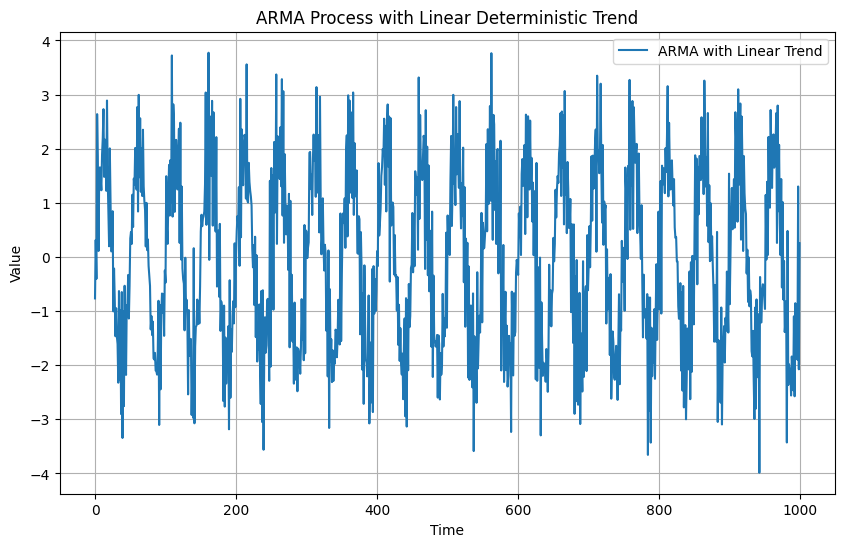

In [ ]:
# randomly generate an ARMA(3,4) process
from pandas import date_range


ar = np.array([0.9, 0.5])
ma = np.array([-0.5, 0.2, 0.1])
arma_process = ArmaProcess(ar, ma)

arma_process = arma_process.generate_sample(nsample=1000)

time = np.arange(1000)  # Time index (0 to 999)
b0 = 0  # Intercept
b1 = 0.005  # Slope (rate of change over time)
b2 = 0.001  # Quadratic trend
# linear_trend = b0 + b1 * time + b2 * time**2  # Quadratic trend

noise = np.random.normal(0, 10, 1000)  # White noise

seasonal_period = 50  # Length of the seasonal cycle
seasonal_amplitude = 2  # Amplitude of the seasonal component

seasonality = seasonal_amplitude * np.sin(2 * np.pi * time / seasonal_period)

# Add the linear trend to the ARMA data
sample_data_with_trend = arma_process + seasonality

# Plot the ARMA data with the trend
plt.figure(figsize=(10, 6))
plt.plot(sample_data_with_trend, label="ARMA with Linear Trend")
# plt.plot(linear_trend, label="Linear Trend", linestyle='--', color='red')
plt.title("ARMA Process with Linear Deterministic Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# ARMA with nonlinear trend


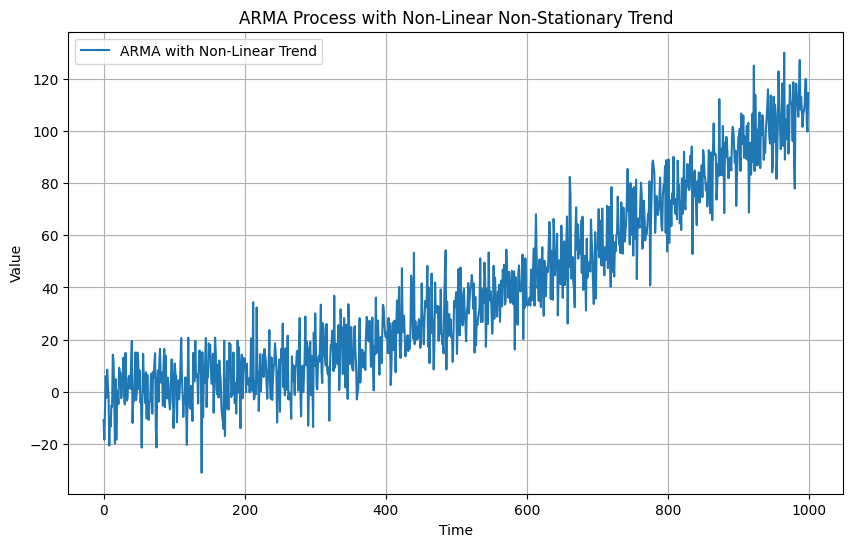

In [ ]:
ar = np.array([0.9, 0.5])
ma = np.array([-0.5, 0.2, 0.1])

# Create ARMA process
arma_process = ArmaProcess(ar, ma)

# Generate sample data from the ARMA process
arma_data = arma_process.generate_sample(nsample=1000)

# Time index (0 to 999)
time = np.arange(1000)

# Define a non-linear trend (e.g., quadratic trend)
b0 = 0  # Intercept
b1 = 0.01  # Linear slope
b2 = 0.0001  # Quadratic term coefficient
nonlinear_trend = b0 + b1 * time + b2 * time**2  # Non-linear trend

# Generate white noise
noise = np.random.normal(0, 10, 1000)  # White noise

# Combine ARMA data with the non-linear trend and noise
sample_data_with_nonlinear_trend = arma_data + nonlinear_trend + noise

# Plot the ARMA data with the non-linear trend
plt.figure(figsize=(10, 6))
plt.plot(sample_data_with_nonlinear_trend, label="ARMA with Non-Linear Trend")
plt.title("ARMA Process with Non-Linear Non-Stationary Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

## Elman


In [ ]:
time_steps = 24
features_size = 1
batch_size = 64
input_shape = (time_steps, features_size)
units = 32
output_size = 1

# # Create a simple RNN that follows the same structure as the custom RNN cell
simple_rnn = layers.SimpleRNN(units, return_sequences=False)  # Output shape will now be (batch_size, 32)

# Input layer
inputs = layers.Input(shape=input_shape)  # 24 time steps, 1 feature per step

# RNN layer
x = simple_rnn(inputs)  # Only the last output is returned, shape will be (batch_size, 32)

# Dense layer to predict a single value
output = layers.Dense(1)(x)  # Output shape will be (batch_size, 1)

# Build the model
model = models.Model(inputs, output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])

X, y = create_sequences(sample_data_with_nonlinear_trend, time_steps)

train_dataset, test_dataset = train_test_tensors(X, y, time_steps, batch_size)
hist = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
model.summary()


NameError: name 'StandardScalar' is not defined

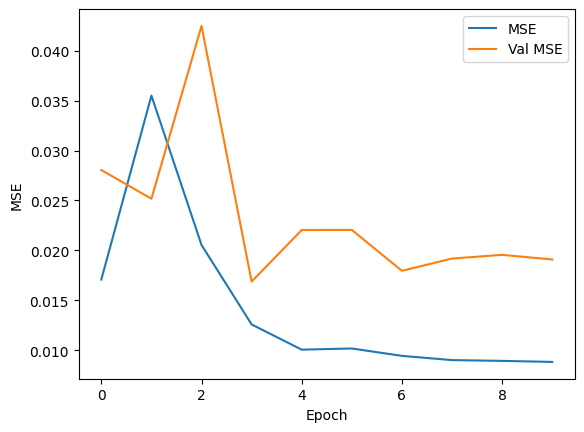

In [ ]:
# prompt: print the mse vs the val mse

import matplotlib.pyplot as plt
plt.plot(hist.history['mean_squared_error'], label='MSE')
plt.plot(hist.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


RNN seems to model noise as well


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


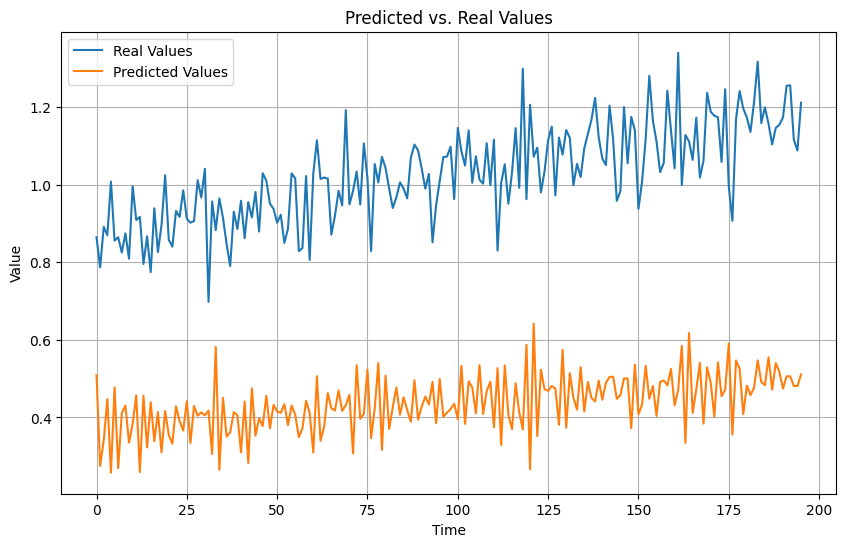

In [ ]:
# prompt: plot predicted vs real values

import matplotlib.pyplot as plt
import numpy as np
# Assuming you have your test dataset and model ready
y_pred = model.predict(test_dataset)

# Extract the true y values from the test dataset
y_true = []
for batch in test_dataset:
  y_true.extend(batch[1].numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Plot the predicted vs. real values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Real Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Predicted vs. Real Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


## Jordan

In [ ]:
# Wrap the custom cell in an RNN layer
custom_cell = JordanRNNCell(units=units, output_size=output_size, activation=tf.nn.tanh)
rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True)

# Build the model
inputs = layers.Input(input_shape)  # (time_steps, input_dim)
outputs, final_state = rnn_layer(inputs)
predictions = layers.Dense(output_size)(final_state)
jordan_RNN = models.Model(inputs, predictions)
jordan_RNN.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])
# jordan_RNN.summary()

X, y = create_sequences(sample_data_with_nonlinear_trend, 24)

train_dataset, test_dataset = train_test_tensors(X, y, 24)

jordan_RNN.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_2 (RNN)                          │ [(None, 24, 1), (None, 1)]  │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = jordan_RNN.fit(train_dataset, epochs=1, validation_data=test_dataset)

prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4375 - mean_squared_error: 2.4375prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4074 - mean_squared_error: 2.4074 - val_loss: 1.9445 - val_mean_squared_error: 1.9445


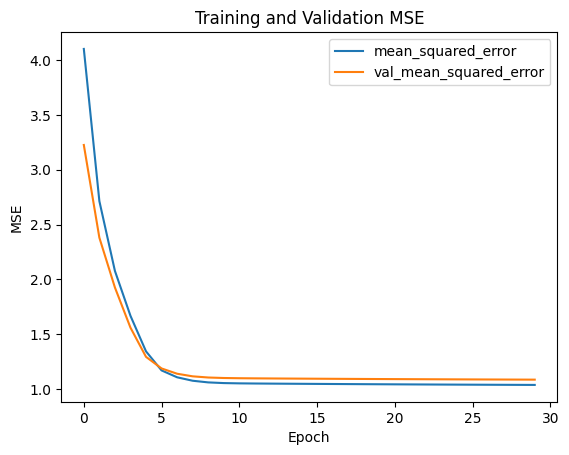

In [ ]:
# prompt: plot the mean squared error vs the val_mse

import matplotlib.pyplot as plt
plt.plot(hist.history['mean_squared_error'], label='mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


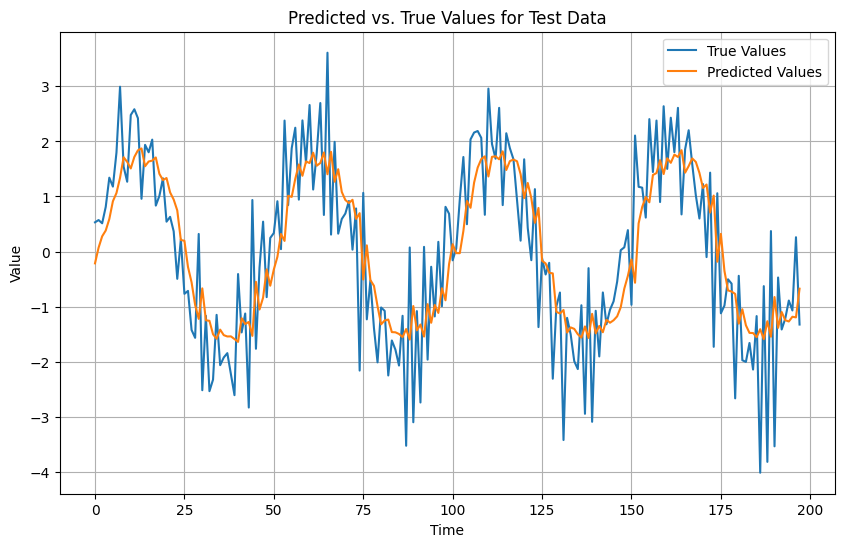

In [ ]:
# prompt: predict values for test dataset and then plot the differing time series

y_pred = jordan_RNN.predict(test_dataset)
# Extract the true values from the test dataset
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy().tolist())

# Plot the predicted vs. true values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. True Values for Test Data')
plt.legend()
plt.grid()
plt.show()


## Multilayer


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_22 (RNN)                         │ (None, 1)                   │             321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
time_steps = 24
features_size = 1
batch_size = 1
input_shape = (time_steps, features_size)
units = 32
output_size = 1


mrnn_layer = layers.RNN(MRNNcell(units=units, output_size = 1, activation = tf.nn.tanh), return_sequences=False)## will return a prediction after processing all inputs


# Input layer (time steps, features)
input_shape = (24, 1)  # Adjust this based on your input data

inputs = layers.Input(shape=input_shape)


# Wrap the input to the MRNN layer with a batch size
mrnn_output = mrnn_layer(inputs)

# Build the model
mrnn_model = models.Model(inputs, mrnn_output)

# Compile the model
mrnn_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Model summary
mrnn_model.summary()


X, y = create_sequences(sample_data_with_nonlinear_trend, time_steps)

train_dataset, test_dataset = train_test_tensors(X, y, time_steps)
hist = mrnn_model.fit(train_dataset, epochs=150, validation_data=test_dataset)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_15 (RNN)                         │ (None, 1)                   │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 440.8148 - mean_squared_error: 440.8148 - val_loss: 8353.6396 - val_mean_squared_error: 8353.6396
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 418.1489 - mean_squared_error: 418.1489 - val_loss: 8178.3608 - val_mean_squared_error: 8178.3608
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 402.1763 - mean_squared_error: 402.1763 - val_loss: 8060.6724 - val_mean_squared_error: 8060.6724
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 381.8007 - mean_squared_error: 381.8007 - val_loss: 7909.2729 - val_mean_squared_error: 7909.2729
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 362.9374 - mean_squared_error: 362.9374 - val_loss: 7675.3652 - val_mean_squared_error: 7675.3652
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 352.2888 - mean_squared_error: 352.2888 - val_loss: 7500.8423 - val_mean_squared_error: 7500.8423
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


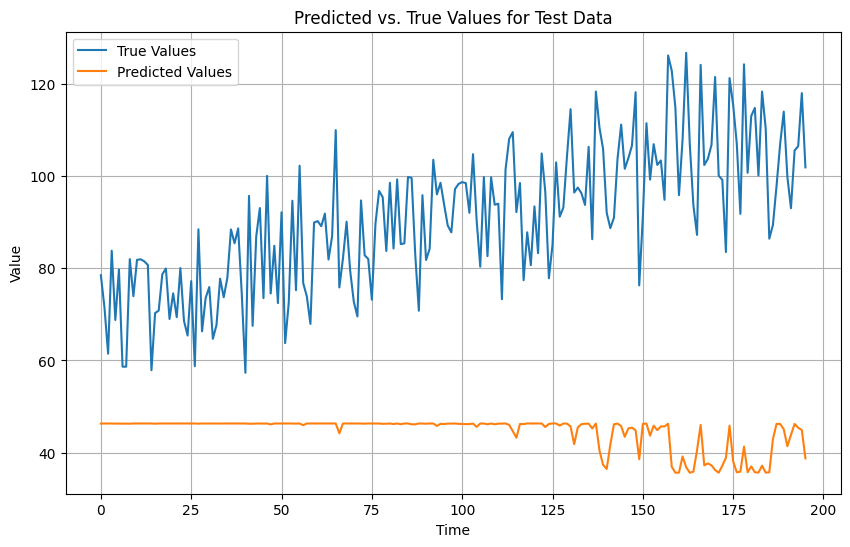

In [ ]:

y_pred = mrnn_model.predict(test_dataset)
# Extract the true values from the test dataset
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy().tolist())

# Plot the predicted vs. true values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. True Values for Test Data')
plt.legend()
plt.grid()
plt.show()


# Seasonality only


## Elman


In [ ]:
time_steps = 24
features_size = 1
batch_size = 64
input_shape = (time_steps, features_size)
units = 32
output_size = 1

# # Create a simple RNN that follows the same structure as the custom RNN cell
simple_rnn = layers.SimpleRNN(units, return_sequences=False)  # Output shape will now be (batch_size, 32)

# Input layer
inputs = layers.Input(shape=input_shape)  # 24 time steps, 1 feature per step

# RNN layer
x = simple_rnn(inputs)  # Only the last output is returned, shape will be (batch_size, 32)

# Dense layer to predict a single value
output = layers.Dense(1)(x)  # Output shape will be (batch_size, 1)

# Build the model
model = models.Model(inputs, output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])

X, y = create_sequences(sample_data_with_trend, time_steps)

train_dataset, test_dataset = train_test_tensors(X, y, time_steps)
# hist = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: print the mse vs the val mse

import matplotlib.pyplot as plt
plt.plot(hist.history['mean_squared_error'], label='MSE')
plt.plot(hist.history['val_mean_squared_error'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


NameError: name 'hist' is not defined

RNN seems to model noise as well


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


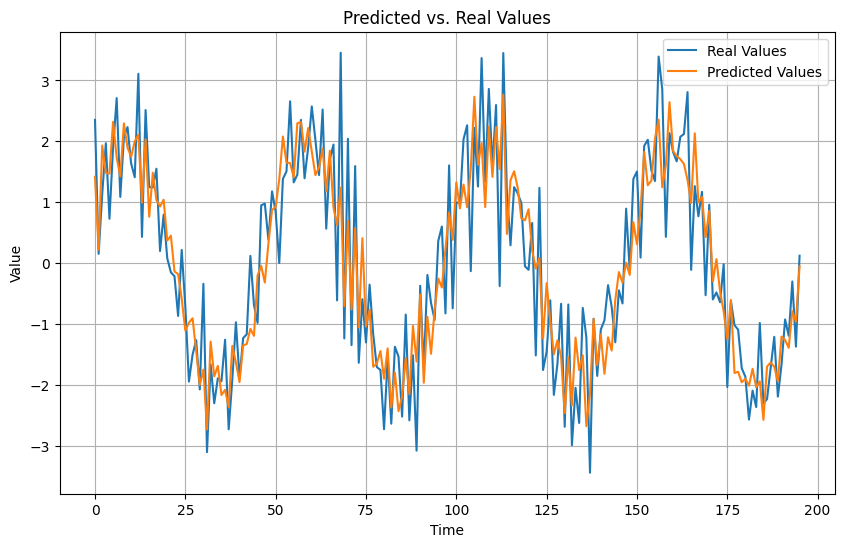

In [ ]:
# prompt: plot predicted vs real values

import matplotlib.pyplot as plt
import numpy as np
# Assuming you have your test dataset and model ready
y_pred = model.predict(test_dataset)

# Extract the true y values from the test dataset
y_true = []
for batch in test_dataset:
  y_true.extend(batch[1].numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Plot the predicted vs. real values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Real Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Predicted vs. Real Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


## Jordan

In [ ]:
# Wrap the custom cell in an RNN layer
custom_cell = JordanRNNCell(units=units, output_size=output_size, activation=tf.nn.tanh)
rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True)

# Build the model
inputs = layers.Input(input_shape)  # (time_steps, input_dim)
outputs, final_state = rnn_layer(inputs)
predictions = layers.Dense(output_size)(final_state)
jordan_RNN = models.Model(inputs, predictions)
jordan_RNN.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])
# jordan_RNN.summary()

X, y = create_sequences(sample_data_with_trend, 24)

train_dataset, test_dataset = train_test_tensors(X, y, 24)

jordan_RNN.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_2 (RNN)                          │ [(None, 24, 1), (None, 1)]  │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = jordan_RNN.fit(train_dataset, epochs=1, validation_data=test_dataset)

prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4375 - mean_squared_error: 2.4375prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/zeros:0", shape=(None, 1), dtype=float32)
prev_output shape: (None, 1)
prev output: Tensor("functional_3_1/rnn_2_1/while/Placeholder_2:0", shape=(None, 1), dtype=float32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4074 - mean_squared_error: 2.4074 - val_loss: 1.9445 - val_mean_squared_error: 1.9445


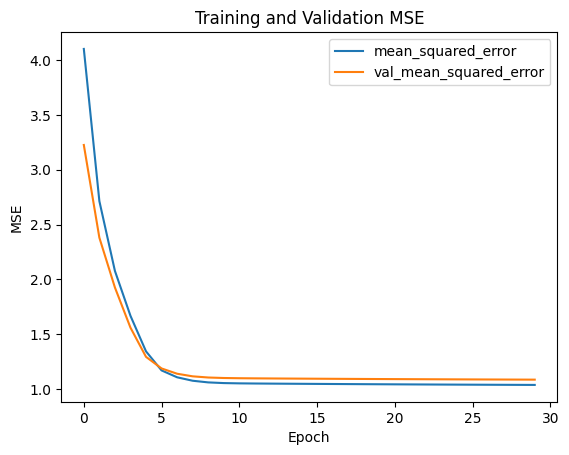

In [ ]:
# prompt: plot the mean squared error vs the val_mse

import matplotlib.pyplot as plt
plt.plot(hist.history['mean_squared_error'], label='mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


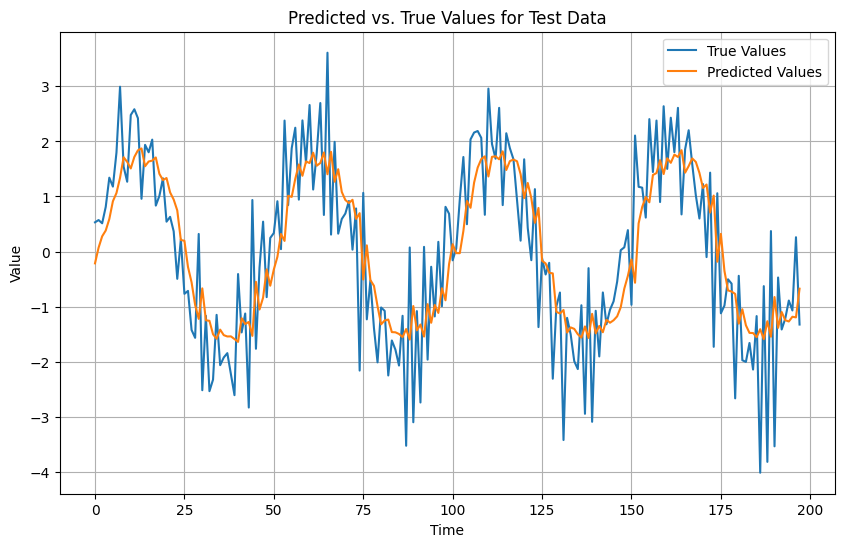

In [ ]:
# prompt: predict values for test dataset and then plot the differing time series

y_pred = jordan_RNN.predict(test_dataset)
# Extract the true values from the test dataset
y_true = []
for _, y in test_dataset:
    y_true.extend(y.numpy().tolist())

# Plot the predicted vs. true values
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. True Values for Test Data')
plt.legend()
plt.grid()
plt.show()


## Multilayer


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_22 (RNN)                         │ (None, 1)                   │             321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
time_steps = 24
features_size = 1
batch_size = 1
input_shape = (time_steps, features_size)
units = 32
output_size = 1


mrnn_layer = layers.RNN(MRNNcell(units=units, output_size = 1, activation = tf.nn.tanh), return_sequences=False)## will return a prediction after processing all inputs


# Input layer (time steps, features)
input_shape = (24, 1)  # Adjust this based on your input data

inputs = layers.Input(shape=input_shape)


# Wrap the input to the MRNN layer with a batch size
mrnn_output = mrnn_layer(inputs)

# Build the model
mrnn_model = models.Model(inputs, mrnn_output)

# Compile the model
mrnn_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Model summary
mrnn_model.summary()


X, y = create_sequences(sample_data_with_trend, time_steps)

train_dataset, test_dataset = train_test_tensors(X, y, time_steps)
hist = mrnn_model.fit(train_dataset, epochs=10, validation_data=test_dataset)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rnn_13 (RNN)                         │ (None, 1)                   │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.7323 - mean_squared_error: 1.7323 - val_loss: 1.0748 - val_mean_squared_error: 1.0748
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8009 - mean_squared_error: 0.8009 - val_loss: 0.8799 - val_mean_squared_error: 0.8799
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6993 - mean_squared_error: 0.6993 - val_loss: 0.7875 - val_mean_squared_error: 0.7875
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6327 - mean_squared_error: 0.6327 - val_loss: 0.7254 - val_mean_squared_error: 0.7254
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5809 - mean_squared_error: 0.5809 - val_loss: 0.6790 - val_mean_squared_error: 0.6790
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5395 - mean_squared_error: 0.5395 - val_loss: 0.6458 - val_mean_squared_error: 0.6458
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5126 - mean_squared_error: 0.5126 - val_loss: 0.6368 - val_mean

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)